# FigureYa196Plus_PanPie_py

**Author:** Ying Ge

In [1]:
from datetime import datetime
from IPython.display import Markdown

current_date = datetime.now().strftime("%Y-%m-%d")
Markdown(f"**Date**: {current_date}")

**Date**: 2025-10-30

## Academic Citation
If you use this code in your work or research, we kindly request that you cite our publication:

Xiaofan Lu, et al. (2025). FigureYa: A Standardized Visualization Framework for Enhancing Biomedical Data Interpretation and Research Efficiency. iMetaMed. https://doi.org/10.1002/imm3.70005

## 需求描述
## Requirement Description

绘制多个饼图展示不同临床预后分期的分布差异，用python实现。

Draw multiple pie charts to show the distribution differences of various clinical prognostic stages using Python.

![](example.png)

出自<https://www.nature.com/articles/s41388-019-1026-9>

Fig. 4 Identification of CNV-driven rRNA metabolism-related genes with clinical relevance.
f, g Pie charts showing the Chi-squared test of clinicopathologic factors for PRE in CRC (f) and LUAD (g) tumor samples from the TCGA. 

## 应用场景
## Application Scenarios
搞清楚输入数据跟图的对应关系、理解每部分代码所画的内容，就可以套用到更多类型的数据上。

Understand the relationship between the input data and the figure, and grasp what each part of the code is plotting, so you can apply the workflow to more types of data.

## 环境设置
## Environment Configuration

In [2]:
#python --version
#pip install jupyter ipykernel pandas numpy matplotlib seaborn
#pip install scipy statsmodels plotly
#pip install notebook nbconvert

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import fisher_exact
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

## 输入文件
## Input files

easy_input.txt

- 第一列sample ID，每行一个sample，扇形大小对应每一类sample的数量；
- 第二列Risk有两类：high和low，对应表格中的两行；
- 第三列往后，对应表格中的各列。

easy_input.txt

- First column (Sample ID): Each row represents one sample. The sector size in visualizations corresponds to the number of samples in each category.
- Second column (Risk): Contains two classes: High and Low, mapped to the two rows in the table.
- Third column onward: Correspond to the columns in the original table.

## 开始画图
## Start plotting

/var/folders/m3/lm0qsytj6gg0dbd7sk2clpr40000gs/T/ipykernel_44383/273953278.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


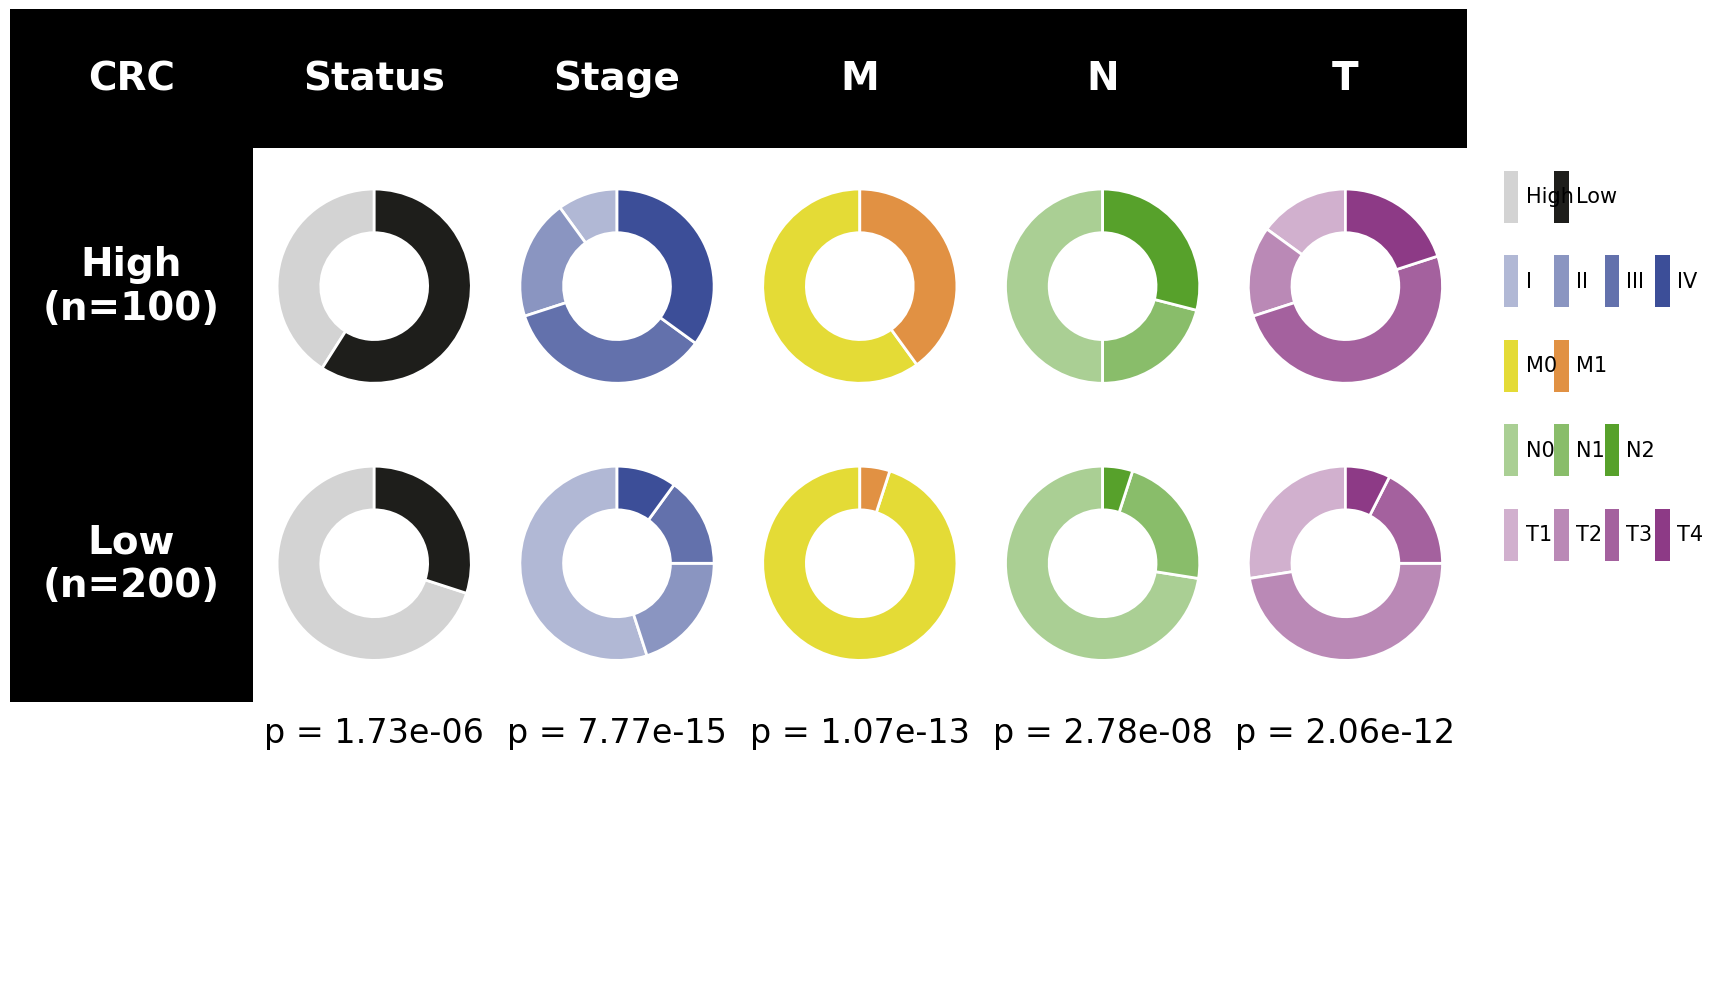

In [4]:
# 读取数据 \ Read data
data = pd.read_csv('easy_input.txt', sep='\t', index_col=0)
 
# 数据预处理 - 计算各组比例和Fisher检验 \ Data preprocessing - calculate group proportions and Fisher's test
def prepare_data(df):
    group_col = 'Risk'  # 分组列 \ Group column
    feature_cols = [col for col in df.columns if col != group_col]  # 特征列 \ Feature columns
    
    pie_data = {}  # 饼图数据 \ Pie chart data
    p_values = {}  # p值字典 \ Dictionary for p-values
    
    for feature in feature_cols:
        # 创建交叉表 \ Create contingency table
        crosstab = pd.crosstab(df[group_col], df[feature])
        
        # Fisher精确检验 \ Fisher's exact test
        if crosstab.shape == (2, 2):
            _, p_val = fisher_exact(crosstab)
        else:
            # 对于多分类，使用卡方检验的p值作为近似 \ For multiclass, use chi-square test as approximation
            from scipy.stats import chi2_contingency
            _, p_val, _, _ = chi2_contingency(crosstab)
        
        p_values[feature] = p_val  # 保存p值 \ Save p-value
        
        # 计算比例 \ Calculate proportions
        pie_data[feature] = {}
        for risk_group in ['High', 'Low']:
            if risk_group in crosstab.index:
                props = crosstab.loc[risk_group] / crosstab.loc[risk_group].sum()
                pie_data[feature][risk_group] = props
    return pie_data, p_values  # 返回结果 \ Return results

# 创建环形饼图函数 \ Function to create donut chart
def create_donut_chart(ax, values, colors, title=None):
    wedges, texts = ax.pie(values, colors=colors, startangle=90, 
                          wedgeprops=dict(width=0.45, edgecolor='white', linewidth=2))
    # 添加中心白色圆圈 \ Add central white circle
    centre_circle = plt.Circle((0,0), 0.55, fc='white')
    ax.add_artist(centre_circle)
    
    if title:
        ax.text(0, -1.3, title, ha='center', va='center', fontsize=10, weight='bold')
    
    ax.set_aspect('equal')

# 创建标题单元格 \ Function to create header cell
def create_header_cell(ax, text):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, facecolor='black'))
    ax.text(0.5, 0.5, text, ha='center', va='center', 
            fontsize=28, color='white', weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# 创建p值单元格 \ Function to create p-value cell
def create_pvalue_cell(ax, p_value):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.text(0.5, 0.95, f'p = {p_value:.2e}', ha='center', va='top', 
            fontsize=24, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)  # 不显示边框 \ Hide borders

# 图例 \ Function to add legend
def add_legend(fig, colors):
    import matplotlib.patches as mpatches
    legend_labels = [
        ('Status', ['High', 'Low']),
        ('Stage', ['I', 'II', 'III', 'IV']),
        ('M', ['M0', 'M1']),
        ('N', ['N0', 'N1', 'N2']),
        ('T', ['T1', 'T2', 'T3', 'T4'])
    ]
    color_keys = ['Status', 'Stage', 'M', 'N', 'T']
    # 图例放右侧，整体右移，分组间距更大 \ Legend on right, more spacing between groups
    ax_legend = fig.add_axes([1.00, 0.18, 0.12, 0.65])  # 更靠右、更宽 \ More right, wider
    ax_legend.axis('off')
    y = 0.95
    for (_, sublabels), color_key in zip(legend_labels, color_keys):
        x = 0.05
        for c, sublabel in zip(colors[color_key], sublabels):
            ax_legend.add_patch(mpatches.Rectangle((x, y-0.04), 0.08, 0.08, color=c, ec='none'))
            ax_legend.text(x+0.12, y, sublabel, ha='left', va='center', fontsize=15)
            x += 0.28  # 横向间距更大 \ More horizontal spacing
        y -= 0.13  # 组间距更大 \ More group spacing

# 主绘图函数 \ Main plotting function
def create_figureya196_python():
    # 准备数据 \ Prepare data
    pie_data, p_values = prepare_data(data)
    
    # 定义颜色 \ Define colors
    colors = {
        'Status': ['#D3D3D3', '#1E1E1B'],
        'Stage': ['#3C4E9866', '#3C4E9899', '#3C4E98CC', '#3C4E98FF'],
        'M': ['#E4DB36', '#E19143'],
        'N': ['#57A12B80', '#57A12BB3', '#57A12BFF'],
        'T': ['#8D3A8666', '#8D3A8699', '#8D3A86CC', '#8D3A86FF']
    }
    
    # 创建图形和网格 \ Create figure and grid
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(4, 6, figure=fig, hspace=0, wspace=0,
         height_ratios=[0.5, 1, 1, 1])  # 第一行高度减半 \ First row half height
    
    # 特征列表 \ Feature list
    features = ['Status', 'Stage', 'M', 'N', 'T']
    
    # 第一行：标题 \ First row: header
    for i, feature in enumerate(['CRC'] + features):
        ax = fig.add_subplot(gs[0, i])
        create_header_cell(ax, feature)
    
    # 第二行：High组 \ Second row: High group
    ax_high_label = fig.add_subplot(gs[1, 0])
    create_header_cell(ax_high_label, 'High\n(n=100)')
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(gs[1, i+1])
        if feature in pie_data and 'High' in pie_data[feature]:
            values = pie_data[feature]['High'].values
            feature_colors = colors[feature][:len(values)]
            create_donut_chart(ax, values, feature_colors)
        else:
            ax.axis('off')
    
    # 第三行：Low组 \ Third row: Low group
    ax_low_label = fig.add_subplot(gs[2, 0])
    create_header_cell(ax_low_label, 'Low\n(n=200)')
    
    for i, feature in enumerate(features):
        ax = fig.add_subplot(gs[2, i+1])
        if feature in pie_data and 'Low' in pie_data[feature]:
            values = pie_data[feature]['Low'].values
            feature_colors = colors[feature][:len(values)]
            create_donut_chart(ax, values, feature_colors)
        else:
            ax.axis('off')
    
    # 第四行：p值 \ Fourth row: p-value
    ax_empty = fig.add_subplot(gs[3, 0])
    ax_empty.axis('off')

    for i, feature in enumerate(features):
        ax = fig.add_subplot(gs[3, i+1])
        if feature in p_values:
            create_pvalue_cell(ax, p_values[feature])
        else:
            ax.axis('off')

    add_legend(fig, colors)

    plt.tight_layout()
    plt.savefig('pieTable_python.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 运行函数 \ Run function
if __name__ == "__main__":
    create_figureya196_python()

## Session Info

In [6]:
import IPython
print(IPython.sys_info())

!jupyter nbconvert --to html FigureYa196Plus_PanPie_py.ipynb

{'commit_hash': '48b00eb07',
 'commit_source': 'installation',
 'default_encoding': 'utf-8',
 'ipython_path': '/Users/mypro/Downloads/FigureYa/.venv/lib/python3.14/site-packages/IPython',
 'ipython_version': '9.6.0',
 'os_name': 'posix',
 'platform': 'macOS-12.7.6-x86_64-i386-64bit-Mach-O',
 'sys_executable': '/Users/mypro/Downloads/FigureYa/.venv/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.14.0 (v3.14.0:ebf955df7a8, Oct  7 2025, 08:20:14) [Clang '
                '16.0.0 (clang-1600.0.26.6)]'}
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand            the subcommand to launch

options:
  -h, --help            show this help message and exit
  --version             show the versions of core jupyter packages and exit
  --config-dir          show Jupyter config dir
  --data-dir            show Jupyter data d